In [1]:
# SNN
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch.functional import quant
from snntorch import utils
from snntorch import spikeplot as splt
from snntorch import spikegen

# Quantization
import brevitas.nn as qnn

# Torch
import torch
from torch import nn
from torch.nn import Module
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Tonic
import tonic
from tonic import DiskCachedDataset
from tonic import MemoryCachedDataset
from tonic.transforms import Compose, ToFrame, Downsample

# Other
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import sys
import pandas as pd
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import pyfenrir as fenrir

In [2]:
class NetUtils():
    @staticmethod
    def beta_clamp(mem, beta):
        """
        Soft-clamping of beta to allow gradients.
        """
        beta_abs = torch.abs(beta)
        # Positive side: approximate clamp(mem - beta_abs, min=0)
        pos_mask = (mem > 0)
        pos_val = F.relu(mem - beta_abs)  # ReLU is differentiable everywhere except 0 (and better than clamp)

        # Negative side: approximate clamp(mem + beta_abs, max=0)
        neg_mask = (mem < 0)
        neg_val = -F.relu(-(mem + beta_abs))  # negative ReLU for negative side

        mem_new = torch.where(pos_mask, pos_val, mem)
        mem_new = torch.where(neg_mask, neg_val, mem_new)

        return mem_new

    @staticmethod
    def mem_clamp(mem, scale, multiplier, bits=12):
        max_val = (2**(bits - 1)) - 1
        max_val = max_val * scale / multiplier
        min_val = -(2**(bits - 1)) - 1
        min_val = min_val * scale / multiplier
        mem = torch.clamp(mem, min=min_val, max=max_val)
        return mem

In [48]:
def plot_mem_spk(mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  """
  Generates a figure with two subplots: membrane potential and output spikes.
  The y-axis ticks are removed from the membrane potential plot.
  
  Args:
    mem (torch.Tensor): The membrane potential data to plot.
    spk (torch.Tensor): The spike data to plot.
    thr_line (float, optional): Y-coordinate for a horizontal threshold line on the membrane plot. Defaults to False.
    vline (float, optional): X-coordinate for a vertical line. Defaults to False.
    title (str, optional): The title for the figure. Defaults to False.
    ylim_max2 (float, optional): The maximum y-limit for the membrane potential plot. Defaults to 1.25.
  """
  # Generate two vertically stacked subplots
  fig, ax = plt.subplots(2, figsize=(8, 4), sharex=True, 
                         gridspec_kw={'height_ratios': [1, 0.4]})

  # Plot membrane potential (top subplot)
  ax[0].plot(mem)
  ax[0].set_ylim([0, ylim_max2])
  ax[0].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[0].set_yticks([])  # This line removes the y-axis ticks
  if title:
    ax[0].set_title(title)
  if thr_line:
    ax[0].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  
  # Plot output spikes (bottom subplot)
  splt.raster(spk, ax[1], s=400, c="black", marker="|")
  plt.ylabel("Output Spikes")
  plt.yticks([])
  if vline:
    ax[1].axvline(x=vline, ymin=0, ymax=1, alpha=0.15, c="black", linewidth=2, zorder=0, clip_on=False)

  plt.xlabel("Time step")
  plt.xlim([0, len(mem)]) # Use the length of the membrane potential for x-axis limit
  fig.tight_layout()
  fig.savefig("/mnt/c/home/temp/lif.pdf")
  plt.show()

In [ ]:
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold)
  mem = mem + (time_step/tau_mem)*(-mem + cur*R) - spk*threshold  # every time spk=1, subtract the threhsold
  return mem, spk

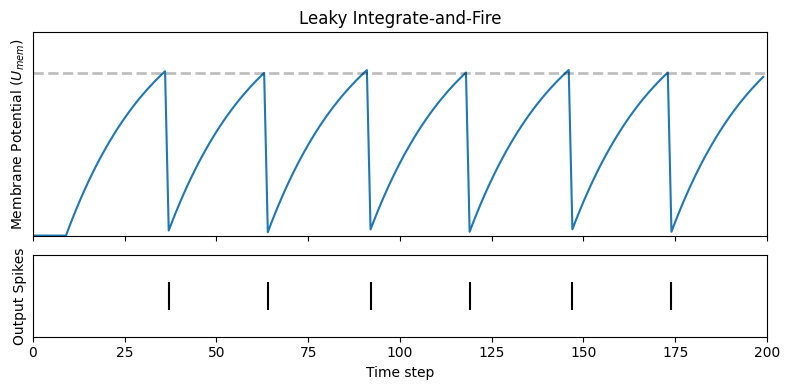

In [50]:
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

num_steps = 200

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_mem_spk(mem_rec, spk_rec, thr_line=1, title="Leaky Integrate-and-Fire")

In [ ]:
lif     = snn.Leaky(beta=1.0, threshold=1.0, learn_threshold=True, reset_mechanism='zero', reset_delay=False)
mem     = lif.init_leaky()
beta    = torch.tensor(1.0)

spk, mem = lif(cur, mem)
mem = NetUtils.beta_clamp(mem, beta)